# Model 1 :
Dataset : MNIST
Applied : created skeleton model and also applied batch normalization to each layer.

In [1]:
!git clone "https://github.com/katipallyvig8899/ERA_7"

Cloning into 'ERA_7'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 9 (delta 0), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (9/9), 254.82 KiB | 5.93 MiB/s, done.


In [2]:
cd /content/ERA_7

/content/ERA_7


In [3]:
pwd

'/content/ERA_7'

In [4]:
!python model.py

In [5]:
from model import *

# Import Libraries

In [6]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [7]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       #transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [8]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 183981233.77it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 93181302.94it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 75832974.01it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 18676988.99it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Dataloader Arguments & Test/Train Dataloaders


In [9]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=32)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Summary of the model

In [10]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Model_1().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 26, 26]             108
              ReLU-2           [-1, 12, 26, 26]               0
       BatchNorm2d-3           [-1, 12, 26, 26]              24
            Conv2d-4           [-1, 16, 24, 24]           1,728
              ReLU-5           [-1, 16, 24, 24]               0
       BatchNorm2d-6           [-1, 16, 24, 24]              32
            Conv2d-7           [-1, 10, 24, 24]             160
         MaxPool2d-8           [-1, 10, 12, 12]               0
            Conv2d-9           [-1, 12, 10, 10]           1,080
             ReLU-10           [-1, 12, 10, 10]               0
      BatchNorm2d-11           [-1, 12, 10, 10]              24
           Conv2d-12             [-1, 12, 8, 8]           1,296
             ReLU-13             [-1, 12, 8, 8]               0
      BatchNorm2d-14             [

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [11]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [12]:
from torch.optim.lr_scheduler import StepLR

model =  Model_1().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    #scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=0.1457282155752182 Batch_id=937 Accuracy=92.46: 100%|██████████| 938/938 [00:24<00:00, 38.79it/s]



Test set: Average loss: 0.0678, Accuracy: 9816/10000 (98.16%)

EPOCH: 1


Loss=0.023362061008810997 Batch_id=937 Accuracy=98.12: 100%|██████████| 938/938 [00:26<00:00, 35.59it/s]



Test set: Average loss: 0.0570, Accuracy: 9823/10000 (98.23%)

EPOCH: 2


Loss=0.037081148475408554 Batch_id=937 Accuracy=98.51: 100%|██████████| 938/938 [00:24<00:00, 38.73it/s]



Test set: Average loss: 0.0427, Accuracy: 9853/10000 (98.53%)

EPOCH: 3


Loss=0.01783006638288498 Batch_id=937 Accuracy=98.79: 100%|██████████| 938/938 [00:24<00:00, 38.89it/s]



Test set: Average loss: 0.0379, Accuracy: 9874/10000 (98.74%)

EPOCH: 4


Loss=0.04358142241835594 Batch_id=937 Accuracy=98.98: 100%|██████████| 938/938 [00:22<00:00, 42.36it/s]



Test set: Average loss: 0.0335, Accuracy: 9891/10000 (98.91%)

EPOCH: 5


Loss=0.016738703474402428 Batch_id=937 Accuracy=99.02: 100%|██████████| 938/938 [00:23<00:00, 40.76it/s]



Test set: Average loss: 0.0356, Accuracy: 9884/10000 (98.84%)

EPOCH: 6


Loss=0.003819554578512907 Batch_id=937 Accuracy=99.08: 100%|██████████| 938/938 [00:20<00:00, 45.69it/s]



Test set: Average loss: 0.0290, Accuracy: 9910/10000 (99.10%)

EPOCH: 7


Loss=0.00796925462782383 Batch_id=937 Accuracy=99.16: 100%|██████████| 938/938 [00:20<00:00, 44.77it/s]



Test set: Average loss: 0.0230, Accuracy: 9924/10000 (99.24%)

EPOCH: 8


Loss=0.04366568848490715 Batch_id=937 Accuracy=99.31: 100%|██████████| 938/938 [00:23<00:00, 40.48it/s]



Test set: Average loss: 0.0229, Accuracy: 9927/10000 (99.27%)

EPOCH: 9


Loss=0.0019994014874100685 Batch_id=937 Accuracy=99.27: 100%|██████████| 938/938 [00:22<00:00, 42.07it/s]



Test set: Average loss: 0.0249, Accuracy: 9917/10000 (99.17%)

EPOCH: 10


Loss=0.004118768498301506 Batch_id=937 Accuracy=99.31: 100%|██████████| 938/938 [00:22<00:00, 41.65it/s]



Test set: Average loss: 0.0227, Accuracy: 9929/10000 (99.29%)

EPOCH: 11


Loss=0.003974624909460545 Batch_id=937 Accuracy=99.39: 100%|██████████| 938/938 [00:22<00:00, 41.65it/s]



Test set: Average loss: 0.0208, Accuracy: 9932/10000 (99.32%)

EPOCH: 12


Loss=0.011034891940653324 Batch_id=937 Accuracy=99.43: 100%|██████████| 938/938 [00:22<00:00, 41.57it/s]



Test set: Average loss: 0.0252, Accuracy: 9925/10000 (99.25%)

EPOCH: 13


Loss=0.0058160703629255295 Batch_id=937 Accuracy=99.41: 100%|██████████| 938/938 [00:21<00:00, 43.13it/s]



Test set: Average loss: 0.0240, Accuracy: 9927/10000 (99.27%)

EPOCH: 14


Loss=0.012910689227283001 Batch_id=937 Accuracy=99.42: 100%|██████████| 938/938 [00:21<00:00, 42.99it/s]



Test set: Average loss: 0.0218, Accuracy: 9934/10000 (99.34%)



# Let's Train and test our model

This time let's add a scheduler for out LR.

Text(0.5, 1.0, 'Test Accuracy')

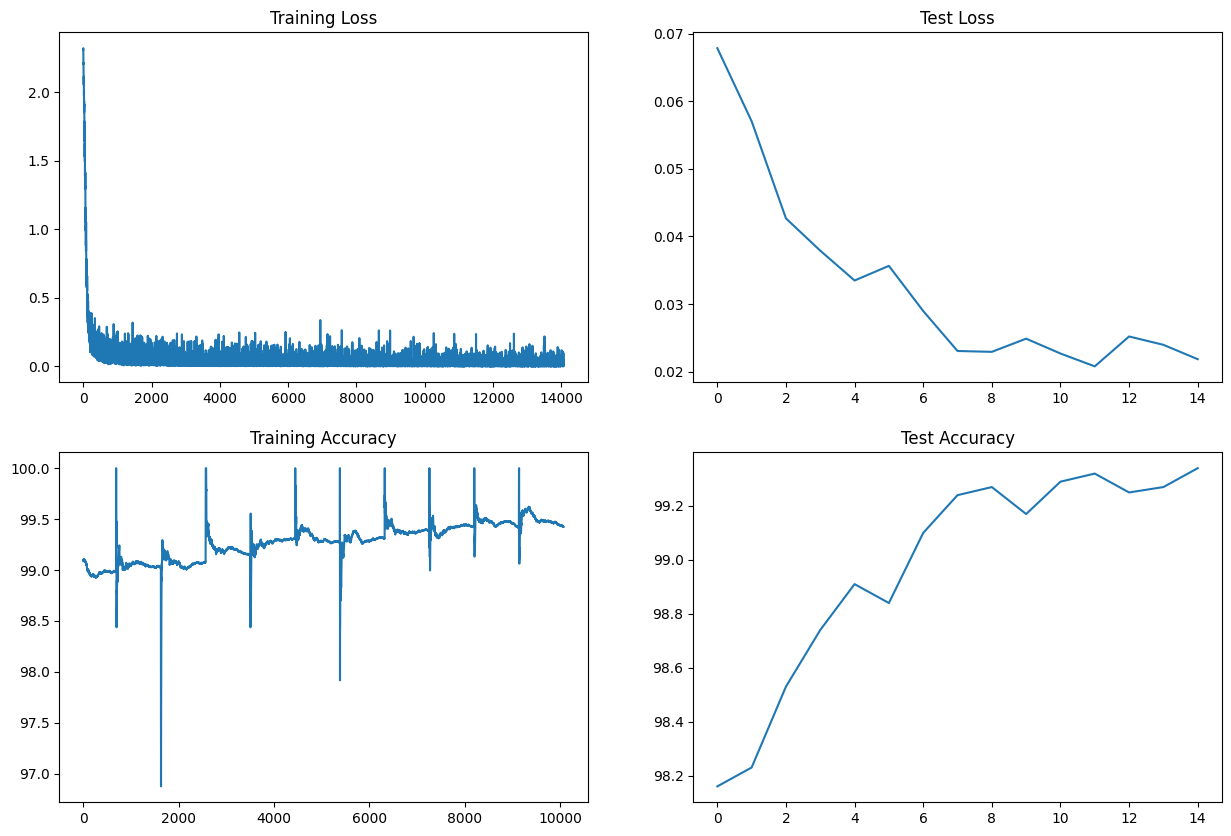

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
t=[t.cpu().item() for t in train_losses]
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

## Target:
-> Created the model skeleton and also applied batch normalization
## Results:
-> Parameters: 7.7k

-> Best Train Accuracy: 99.43

-> Best Test Accuracy: 99.34 (14th Epoch)

## Analysis:
-> model is underfitting at starting but after few epochs model is overfitting. We are getting best test accuracy around 99.34 % but still we are not getting our target accuracy 99.4 % within 15 epochs.  